# **Chatbot With Neural Network**

<b>Chatbot</b> merupakan bagian dari Natural Language Processing yang digunakan untuk percakapan dengan pengguna melalui teks dan ucapan.

Dalam tahapan Chatbot ini ada tahapan yang harus kita perhatikan yaitu,

1. Import Library
2. Load Dataset
3. Preprocessing Data
4. Input Length, Output Length and Vocabulary
5. Neural Network Model
6. Model Analysis
7. Testing
8. Save Model

Dalam proyek ini, kita akan membuat chatbot tentang SURVEIL

# **Load Google Drive**

menyimpan file datasetg kita di Google Drive dengan dengan cara klik pada menu "**Mount Drive**" maka akan keluar code dibawah ini.

**Notes:** Mohon dirunning terlebih dahulu

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setelah dirunning maka ada notifikasi untuk **Permit this notebook to your access Google Drive** lalu pilih izinkan dan akan diproses ke dalam login akun google kita dan pilih izinkan dan akan keluar seperti gambar dibawah ini.

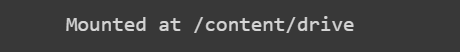

**Notes : Penginstalan dengan tanda -q maksudnya adalah mode quiet atau diam sehingga tidak mengeluarkan output saat eksekusi**

# **Import Library**

Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang saya gunakan yaitu NumPy untuk komputasi matematika, Matplotlib untuk visualisasi model data, Natural Language Toolkit atau NLTK untuk pengolahan teks, Pandas untuk membaca data, serta Tensorflow untuk model pada data menggunakan algoritma LSTM dan Jaringan Syaraf Tiruan (Neural Network).

In [32]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, GRU

## **Download NLTK Package**

Natural Language Toolkit (NLTK) adalah software open source python yang mendukung pengembangan NLP. Library NLTK merupakan tools NLP standar yang dikemabangkan untuk penelitian dan pendidikan.

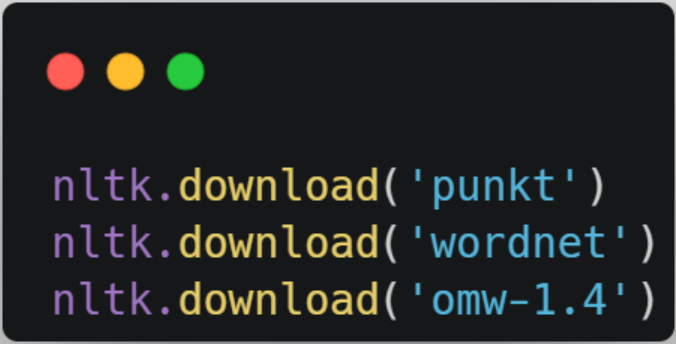

In [33]:
# Package sentence tokenizer
nltk.download('punkt')

# Package lemmatization
nltk.download('wordnet')

# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Load Dataset Json**

Setelah import library, tahapan selanjutnya adalah me-load dataset yang telah disediakan. Dataset yang digunakan berupa format **.json** yang sangat cocok untuk membuat model Chatbot.

Data Json merupakan data yang termasuk dalam *semi structured* yang dimana data ini menampung beberapa bagian data seperti **tag**, **pattern**, **context**, dan **response**. Data yang dipakai dalam proyek ini menggunakan dataset manual yang diciptakan oleh student ORBIT batch 5 <b>SURVEILBOT</b>.



In [34]:
# Importing the dataset
with open('/content/drive/MyDrive/SIB ORBIT/SURVEILBOT.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [35]:
# Cetak data keseluruhan
data

,patterns,tags
0,Hallo,greeting
1,P,greeting
2,Hai,greeting
3,Halo,greeting
4,Hei,greeting
...,...,...
257,Bayar?,biaya_surveil
258,Free?,biaya_surveil
259,Apakah ada biaya yang dikeluarkan?,biaya_surveil
260,Ada biaya?,biaya_surveil


In [36]:
# Cetak data baris pertama sampai baris kelima
data.head()

,patterns,tags
0,Hallo,greeting
1,P,greeting
2,Hai,greeting
3,Halo,greeting
4,Hei,greeting


In [37]:
# Cetak data baris ke-70 sampai baris akhir
data.tail()

,patterns,tags
257,Bayar?,biaya_surveil
258,Free?,biaya_surveil
259,Apakah ada biaya yang dikeluarkan?,biaya_surveil
260,Ada biaya?,biaya_surveil
261,Biaya,biaya_surveil


Data yang telah kita miliki dalam format JSON yang dapat digunakan melalui pandas dengan cara konversi. Data JSON yang saya miliki didapat dengan cara manual dengan mengambil beberapa referensi.

# **Preprocessing The Data**

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

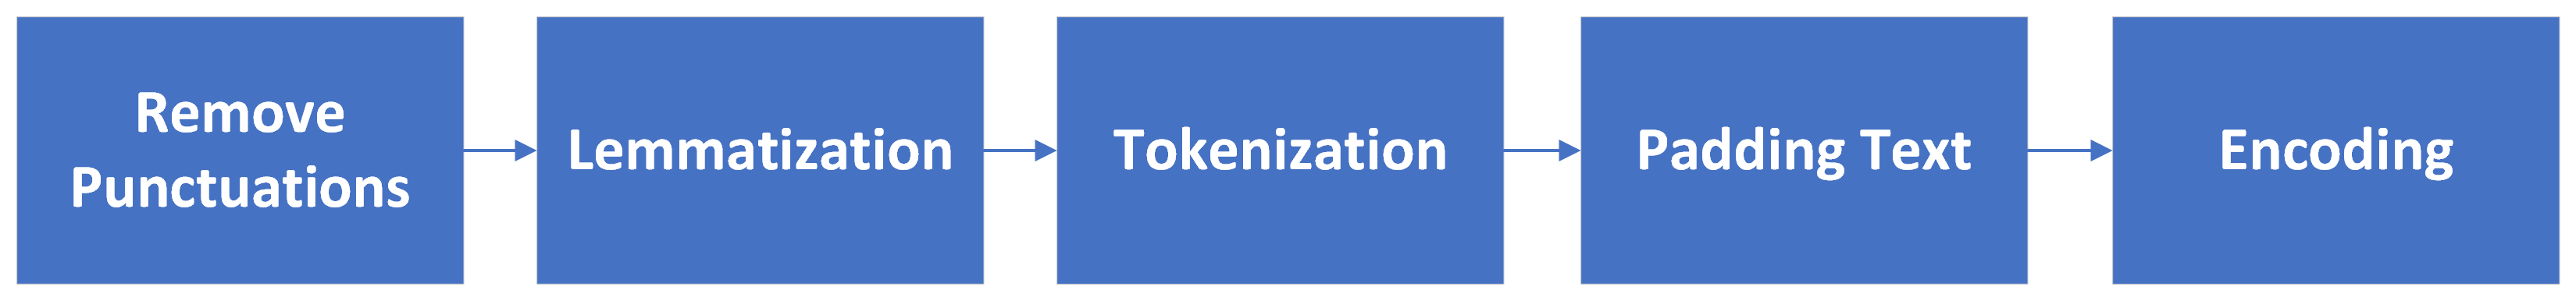

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

Kelima tahapan pemrosesan teks ini dijelaskan pada bagian langkah selanjutnya.

## **Remove Punctuations**

Tahapan praproses pada data teks yang pertama adalah menghapus punktuasi atau tanda baca seperti *special character* yaitu **'!'** (**tanda seru**) **','** (**tanda koma**) **'.'** (**tanda titik sebagai berhenti**) '**?**' (**tanda tanya**) dan tanda baca yang lain. Tahapan ini gunanya untuk mempermudah pemrosesan data teks yang akan kita olah.

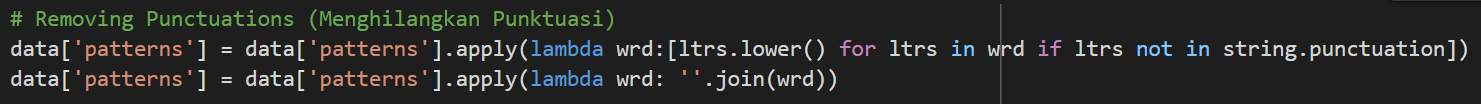

**Lengkapi kode dibawah ini!**

In [38]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,p,greeting
2,hai,greeting
3,halo,greeting
4,hei,greeting
...,...,...
257,bayar,biaya_surveil
258,free,biaya_surveil
259,apakah ada biaya yang dikeluarkan,biaya_surveil
260,ada biaya,biaya_surveil


## **Lemmatization (Lematisasi)**

Setelah menghapus punktuasi atau tanda baca, tahapan selanjutnya yaitu Lematisasi atau Lemmatization. **Apa itu Lematisasi?**

Lematisasi atau Lemmatization adalah proses dimana merujuk pada melakukan sesuatu menggunakan vocabulary atau kosakata dan analisis morfologi kata-kata untuk menghilangkan *inflectional endings only* dan untuk mengembalikan bentuk *dictionary* (kata dalam kamus) dari sebuah kata yang dikenal sebagai ***lemma***.

Contoh Lematisasi : **Menggunakan** (Kata Imbuhan) -> **Guna** (Kata Dasar)

Dalam contoh berikut proses lematisasi awalnya data teks menggunakan kata imbuhan yaitu **Menggunakan** dimana **meng-** + **guna** (kata dasar yang berawalan vokal g) + **kan** (sebagai akhiran) diubah menjadi kata dasar yaitu '**Guna**'.

Proses ini dimana menghilangkan Prefiks pada imbuhan (**Meng-**) dan Suffiks pada (**-kan**).

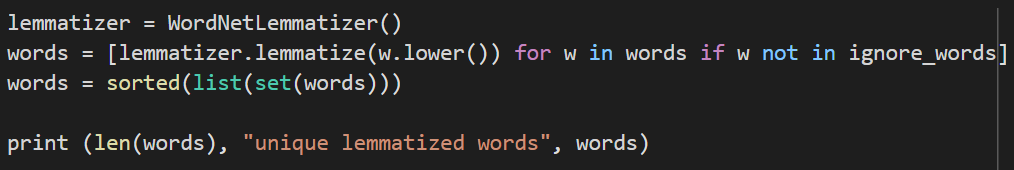

In [39]:
# Lematisasi atau Lemmatization
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

324 unique lemmatized words ["'", "'start", ',', '.', 'ada', 'adalah', 'afternoon', 'ai', 'aja', 'akun', 'alat', 'algoritma', 'anda', 'antara', 'apa', 'apakah', 'apalagi', 'apasih', 'aplikasi', 'aplikasimu', 'atas', 'atau', 'atribut', 'ayo', 'bagaimana', 'bai', 'balik', 'bantu', 'bantuan', 'bantuannya', 'banyak', 'batasan', 'bayar', 'bekerja', 'beradaptasi', 'berapa', 'berbagai', 'berbayar', 'berbeda', 'berbicara', 'beri', 'berikan', 'berjumpa', 'bertemu', 'berterima', 'besok', 'biaya', 'biayanya', 'bicara', 'bisa', 'bisakah', 'bro', 'buatan', 'bye', 'byee', 'cara', 'caranya', 'cepat', 'ceritakan', 'computer', 'dadah', 'dah', 'dalam', 'dan', 'dapat', 'dari', 'data', 'definisi', 'definisikan', 'dengan', 'denganmu', 'deteksi', 'deteksiatribut_surveil', 'deteksimu', 'deteksinya', 'di', 'diandalkan', 'dibalik', 'diberikan', 'dicapai', 'dideteksi', 'digunakan', 'diidentifikasi', 'dijaga', 'dijelaskan', 'dikeluarkan', 'dimaksud', 'dipakai', 'dipake', 'dipegang', 'diperlukan', 'disesuaikan', 

### **Menyortir Data Kelas Tags**

In [40]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

10 classes ['biaya_surveil', 'carakerja_SURVEIL', 'deteksiatribut_SURVEIL', 'goodbye', 'greeting', 'pedoman_SURVEIL', 'surveil', 'teknologi_SURVEIL', 'terimakasih', 'tujuan_SURVEIL']


### **Mencari Jumlah Keseluruhan Data Teks**

In [41]:
# documents = combination between patterns and intents
print (len(documents), "documents")

7470 documents


## **Tokenization (Tokenisasi)**

Setelah proses lematisasi dan mencari tahu data classes dan jumlah keseluruhan data patterns dengan intents-nya. Maka, tahapan selanjutnya proses tokenisasi. **Apa itu Tokenisasi?**

Tokenisasi adalah suatu proses memberikan urutan karakter dan sebuah unit dokumen terdefinisi. Tokenisasi juga merupakan tugas untuk memecah kalimat menjadi bagian-bagian yang disebut dengan '**Token**' dan menghilangkan bagian tertentu seperti tanda baca.

Contohnya: **Aku Pergi Ke Makassar** -> '**Aku**' '**Pergi**' '**Ke**' '**Makassar**'

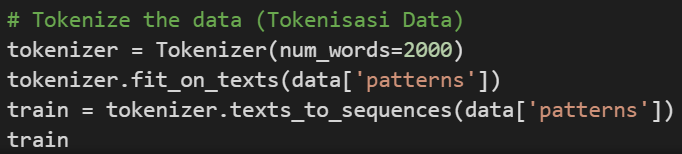

In [42]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[166],
 [167],
 [103],
 [74],
 [168],
 [169],
 [170],
 [104],
 [105],
 [106],
 [107],
 [171],
 [108],
 [172],
 [173],
 [174],
 [47, 104],
 [47, 106],
 [47, 108],
 [54, 105],
 [54, 175],
 [54, 107],
 [176, 1],
 [103, 177, 1],
 [1, 16, 109, 110, 178],
 [74, 1, 2, 4, 16, 14, 179],
 [2, 75, 180, 31],
 [181],
 [74, 1, 29, 111, 112],
 [2, 75],
 [2, 75, 1],
 [182],
 [1, 29, 183, 24, 40, 48],
 [15, 184],
 [76, 55],
 [76, 185],
 [186, 76],
 [1],
 [2, 49, 1],
 [113, 24, 1],
 [77, 1],
 [187, 55, 78, 1],
 [188, 1],
 [189, 2, 49, 1],
 [79, 2, 190],
 [2, 4, 191, 78, 1],
 [113, 25, 56, 24, 1],
 [192, 1],
 [5, 114, 55, 78, 1],
 [193, 194, 80, 1],
 [2, 1],
 [1, 49, 2],
 [1, 195],
 [1, 2],
 [1],
 [14, 115],
 [14, 2],
 [14, 115],
 [196, 1],
 [31, 2],
 [2, 31],
 [2, 21, 81, 57, 1],
 [2, 21, 116, 117, 41, 58, 1],
 [2, 21, 1],
 [1, 2, 21, 81, 57, 118],
 [6, 18, 26, 21, 41, 58, 1, 11, 59, 9, 197],
 [1, 60, 14, 119, 2, 4, 18, 198, 34, 118],
 [6, 82, 2, 4, 120, 21, 81, 11, 121, 40, 48, 11, 59, 9, 41, 1],
 [6,

## **Padding**

Setelah memproses tokenisasi yang dimana memecah kalimat menajdi bagian-bagian yang disebut token yang digunakan untuk mengolah data teks pada AI Chatbot maka tahapan selanjutnya adalah Padding.
**Apa itu Padding?**

**Padding** adalah Suatu proses untuk mengubah setiap sequence agar memiliki panjang yang sama. Pada padding, setiap sequence dibuat sama panjang dengan menambahkan nilai 0 secara suffiks atau prefiks hingga mencapai panjang maksimum sequence. Selain itu padding juga dapat memotong sequence hingga panjangnya sesuai dengan panjang maksimum sequence.

Padding juga adalah proses untuk membuat setiap kalimat pada teks memiliki panjang yang seragam. Sama seperti melakukan resize gambar, agar resolusi setiap gambar sama besar. Untuk menggunakan padding bisa impor library **pad_sequence**. Kemudian buat panggil fungsi pad_sequence() dan masukkan sequence hasil tokenisasi sebagai parameternya.

Contohnya: `sequences_samapanjang = pad_sequences(sequences)`

Yang nantinya akan dikeluarkan menjadi angka dengan awalan 0 seperti gambar dibawah ini.

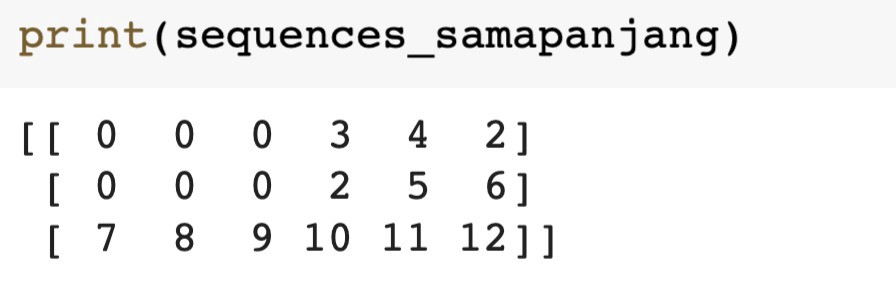

In [43]:
# Apply padding
x_train = pad_sequences(train)
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0 166]
 [  0   0   0 ...   0   0 167]
 [  0   0   0 ...   0   0 103]
 ...
 [  0   0   0 ...  73   4 321]
 [  0   0   0 ...   0  29  73]
 [  0   0   0 ...   0   0  73]]


Hasil setelah padding adalah setiap sequence memiliki panjang yang sama. Padding dapat melakukan ini dengan menambahkan 0 secara default pada awal sequence yang lebih pendek.

## **Encoding Text**

Setelah tahapan proses Padding pada suatu teks maka proses terakhir dalam pemrosesan teks adalah tahapan Encoding. **Apa itu Encoding?**

Encoding merupakan suatu konversi atau pengkodean yang dimana data kategorik seperti huruf atau data teks menjadi data numerik atau angka menyesuaikan dengan data label yang digunakan. Pada proses tahapan ini, encoding mengubah data teks pada kolom data tags menjadi data numerik dengan bahasa biner komputer yaitu 0 dan 1.

Tujuan dari encoding ini adalah mempermudah saat proses komputasi data teks dan modelling.

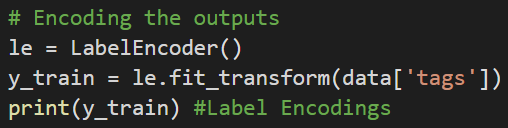

In [44]:
# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [45]:
print(y_train) #Label Encodings

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0
 0 0 0]


Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

# **Input Length, Output Length and Vocabulary**

In [46]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

16


In [47]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  321
output length:  10


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari data train atau latih yang akan diproses pada algoritma Neural Network atau Jaringan Syaraf Tiruan.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

## **Save Model Words & Classes**

Setelah dilakukan pemrosesan teks yang dilakukan lima tahap maka kita bisa simpan model pemrosesan teks tersebut dengan menggunakan format pickle.

Hal ini biasanya digunakan untuk membuat hubungan model yang telah dilatih dengan model pemrosesan teks.

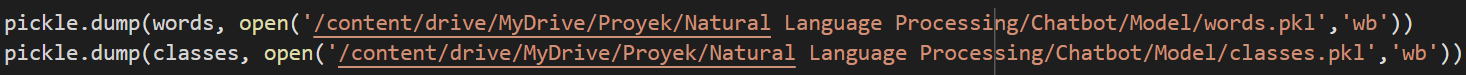

In [48]:
pickle.dump(words, open('/content/drive/MyDrive/SIB ORBIT/Model/words.pkl','wb'))
pickle.dump(classes, open('/content/drive/MyDrive/SIB ORBIT/Model/classes.pkl','wb'))


## **Save Label Encoder & Tokenizer**

In [49]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

# **Neural Network Model**

Setelah menyimpan model untuk pemrosesan teks, tahapan selanjutnya adalah melakukan modelling untuk Chatbot dengan menggunakan algoritma Neural Network atau Jaringan Syaraf Tiruan dengan algoritma LSTM (Long Short Term Memory). **Apa itu Algoritma LSTM?**

**LSTM (Long Short Term Memory)** merupakan algoritma Deep Learning yang populer dan cocok digunakan untuk membuat prediksi dan klasifikasi yang berhubungan dengan waktu dan data teks.

Algoritma ini bisa dikatakan pengembangan atau salah satu jenis dari algoritma RNN (Recurrent Neural Network). Dalam algoritma RNN, output dari langkah terakhir diumpankan kembali sebagai input pada langkah yang sedang aktif. Namun, algoritma RNN memiliki kekurangan yaitu tidak dapat memprediksi kata yang disimpan dalam memori jangka panjang.

Nah, algoritma LSTM dirancang untuk mengatasi kelemahan tersebut, namun tetap mempertahankan kelebihan yang ada pada algoritma RNN dimana RNN mampu memberikan prediksi yang lebih akurat dari informasi terbaru.

Algoritma LSTM pertama kali dikembangkan oleh Hochreiter dan Schmidhuber.  Algoritma ini mampu menyimpan informasi untuk jangka waktu yang lama. Hal ini kemudian dapat digunakan untuk memproses, memprediksi, dan mengklasifikasikan informasi berdasarkan data deret waktu.

Struktur algoritma LSTM terdiri atas neural network dan beberapa blok memori yang berbeda. Blok memori ini disebut sebagai cell.  State dari cell dan hidden state akan diteruskan ke cell berikutnya.

Seperti yang ditunjukkan pada gambar di bawah, bangun berbentuk persegi panjang berwarna biru adalah **ilustrasi cell** pada LSTM.

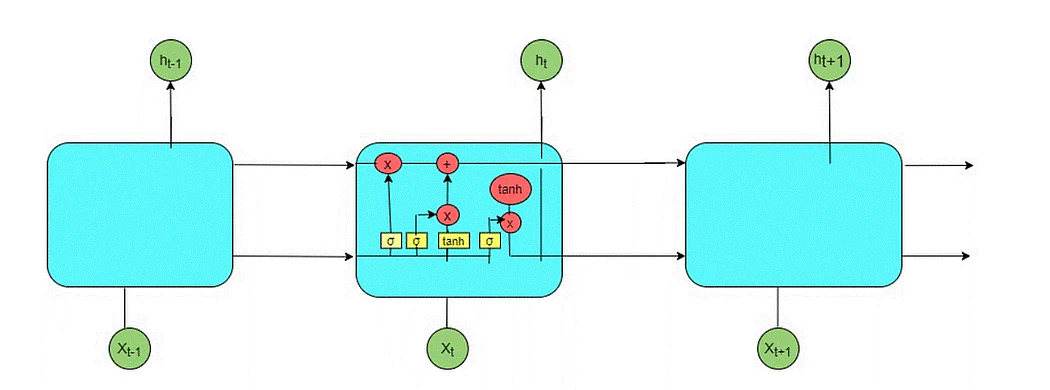

Informasi yang dikumpulkan oleh algoritma LSTM kemudian akan disimpan oleh cell dan manipulasi memori dilakukan oleh komponen yang disebut dengan gate. Ada tiga jenis gate pada algoritma LSTM, di antaranya  Forget gate, Input gate, dan  Output gate. Sumber : [Trivusi](https://www.trivusi.web.id/2022/07/algoritma-lstm.html)

Jaringan syaraf dalam kasus chatbot ini yang terdiri dari lapisan atau *layer* embedding yang merupakan salah satu hal yang paling kuat di bidang pemrosesan bahasa alami atau NLP. output atau keluaran dari lapisan (*layer*) embedding adalah input (masukan) data teks dari lapisan berulang (*recurrent*) dengan layer LSTM gate (Lapisan Gerbang **Long Shot Term Memory)**. Kemudian, output atau keluaran diratakan dan lapisan Dense digunakan dengan fungsi aktivasi **Softmax** yang dimana implementasi chatbot ini memiliki data label lebih dari dua kelas.

Bagian utama dalam pemodelan chatbot ini adalah lapisan embedding yang memberikan nilai vektor yang sesuai untuk setiap kata dalam data teks yang telah dimasukkan.

In [50]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [51]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [52]:
# Menampilkan Parameter Model
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 16, 10)            3220      
                                                                 
 lstm_1 (LSTM)               (None, 16, 10)            840       
                                                                 
 flatten_1 (Flatten)         (None, 160)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1610      
                                                                 
Total params: 5670 (22.15 KB)
Trainable params: 5670 (22.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
# Training the model (Latih model data sampai 400 kali)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
9/9 [==============================] - 3s 8ms/step - loss: 2.3017 - accuracy: 0.1183
Epoch 2/400
9/9 [==============================] - 0s 8ms/step - loss: 2.2944 - accuracy: 0.1794
Epoch 3/400
9/9 [==============================] - 0s 8ms/step - loss: 2.2862 - accuracy: 0.2023
Epoch 4/400
9/9 [==============================] - 0s 9ms/step - loss: 2.2753 - accuracy: 0.2023
Epoch 5/400
9/9 [==============================] - 0s 8ms/step - loss: 2.2628 - accuracy: 0.2137
Epoch 6/400
9/9 [==============================] - 0s 8ms/step - loss: 2.2447 - accuracy: 0.2099
Epoch 7/400
9/9 [==============================] - 0s 9ms/step - loss: 2.2308 - accuracy: 0.1870
Epoch 8/400
9/9 [==============================] - 0s 7ms/step - loss: 2.2162 - accuracy: 0.1832
Epoch 9/400
9/9 [==============================] - 0s 7ms/step - loss: 2.2027 - accuracy: 0.2290
Epoch 10/400
9/9 [==============================] - 0s 9ms/step - loss: 2.1861 - accuracy: 0.2519
Epoch 11/400
9/9 [===========

# **Model Analysis**

Setelah menjalankan pelatihan model dengan algoritma Neural Network dan LSTM serta telah mengetahui hasil akurasi pada step terakhir. Maka, tahapan selanjutnya adalah menganalisa model dengan visualisasi plot akurasi dan loss untuk melihat hasil akurasi dari algoritma pelatihan model Neural Network dengan LSTM tersebut.

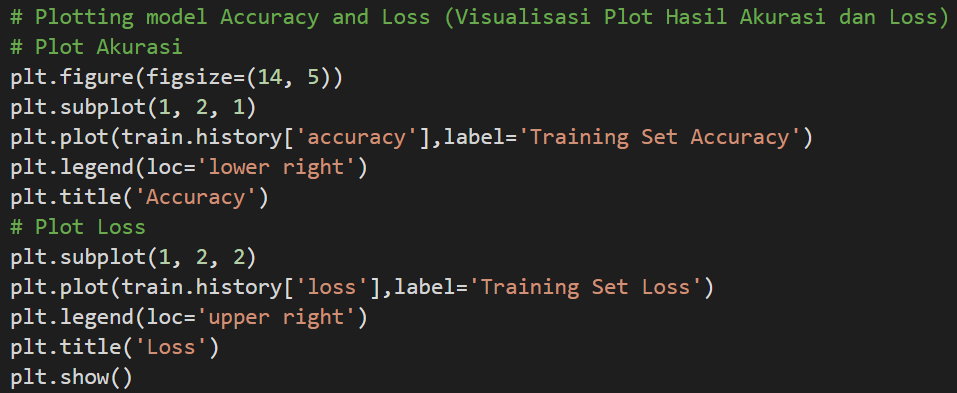

**Lengkapi Kode Dibawah Ini!**

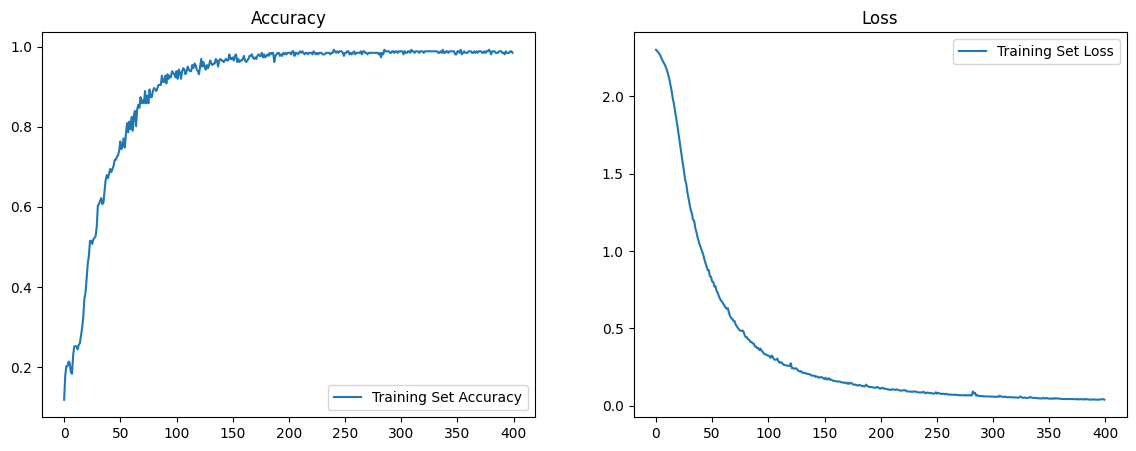

In [54]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Terlihat bahwa model pelatihan chatbot dengan algoritma Neural Network + LSTM menghasilkan model yang baik dan tidak terjadi overfitting atau underfitting. Sehingga, model ini layak dilakukan pengujian dan evaluasi model chatbot yang diperoleh.

# **Testing Chatbot Dan Tambahkan Suara Pada Chatbot**

Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan algoritma Neural Network dan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya.

Pada pengujian ini menggunakan metode input atau masukan sesuai dengan kalimat pertanyaan yang dimasukkan.

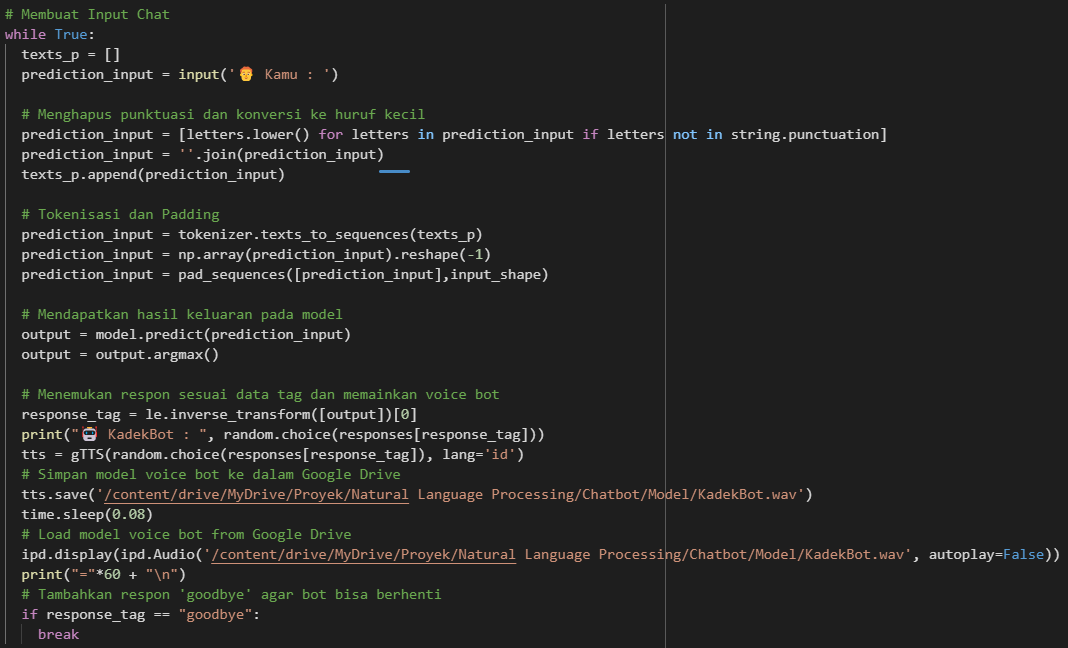

**Lengkapi Kode Dibawah ini!**

In [55]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👩🏻/🧑🏻 Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)


  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("🤖 SURVEILBot : ", random.choice(responses[response_tag]))

  # Tambahkan respon 'goodbye' agar bot bisa berhenti
  if response_tag == "goodbye":
    break

👩🏻/🧑🏻 Kamu : hi
1/1 [==============================] - 0s 431ms/step
🤖 SURVEILBot :  Halo! Jangan ragu untuk bertanya tentang konsep dan implementasi SURVEIL
👩🏻/🧑🏻 Kamu : kamu siapa
1/1 [==============================] - 0s 31ms/step
🤖 SURVEILBot :  SURVEIL adalah solusi pintar berbasis website yang mengimplementasikan kecerdasan buatan berupa computer vision untuk meningkatkan keselamatan di tempat kerja dengan bekerja mendeteksi alat keselamatan kerja pada foto, video ataupun realtime.
👩🏻/🧑🏻 Kamu : bagaimana cara kerjanya
1/1 [==============================] - 0s 20ms/step
🤖 SURVEILBot :  SURVEIL dirancang untuk mengenali objek dari berbagai sudut pandang, memastikan pemantauan keselamatan yang komprehensif di seluruh lingkungan kerja.
👩🏻/🧑🏻 Kamu : cara menggunakan surveil
1/1 [==============================] - 0s 20ms/step
🤖 SURVEILBot :  SURVEIL adalah solusi pintar berbasis website yang menggabungkan kecerdasan buatan dan computer vision untuk meningkatkan keselamatan di tempat ke

# **Save The Model**

Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. Penyimpanan file model bisa langsung secara transient atau bisa taruh di Google Drive.

In [56]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('/content/drive/MyDrive/SIB ORBIT/Model/chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
